<h1>Wheather Prediction Model</h1>

In [1]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

In [2]:
df=pd.read_excel("Pumpkin.xlsx")
df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Çerçevelik
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Çerçevelik
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,Çerçevelik
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,Çerçevelik
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,Çerçevelik


In [3]:
#check for NA's 
df.isna().sum()

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Convex_Area          0
Equiv_Diameter       0
Eccentricity         0
Solidity             0
Extent               0
Roundness            0
Aspect_Ration        0
Compactness          0
Class                0
dtype: int64

<p>Does not contain NA's</p>

In [4]:
for column in df.columns:
    number_of_distinct_values = len(df[column].unique())
    print(f"{column}: {number_of_distinct_values} distinct values")

Area: 2424 distinct values
Perimeter: 2490 distinct values
Major_Axis_Length: 2499 distinct values
Minor_Axis_Length: 2497 distinct values
Convex_Area: 2445 distinct values
Equiv_Diameter: 2424 distinct values
Eccentricity: 1295 distinct values
Solidity: 166 distinct values
Extent: 1392 distinct values
Roundness: 1480 distinct values
Aspect_Ration: 2237 distinct values
Compactness: 1405 distinct values
Class: 2 distinct values


<b>Variables that have more than 2 Possible Values and need to be split up:</b>
<ul>
<li>Class (Çerçevelik, Ürgüp Sivrisi)</li>
</ul>
<p>If The class is not Çerçevelik it will be the other, also hoping that the special letters work</p>

In [5]:
# this makes multiple columns with the variable (Separate for yes/no)
from sklearn.preprocessing import OneHotEncoder
variables = ['Class']

# use encoder
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [6]:
df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class_Çerçevelik,Class_Ürgüp Sivrisi
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,1,0
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,1,0
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,1,0
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,1,0
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,1,0


In [7]:
df = df.drop('Class_Ürgüp Sivrisi', axis=1)

In [8]:
df.columns

Index(['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length',
       'Convex_Area', 'Equiv_Diameter', 'Eccentricity', 'Solidity', 'Extent',
       'Roundness', 'Aspect_Ration', 'Compactness', 'Class_Çerçevelik'],
      dtype='object')

<h3> Data Cleaning</h3>

In [9]:
#this is just a test if this kind of outlierremoval would work
#from scipy import stats
#dt = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
#dt.head()
#dt in data wrangler would have around 81 less rows

In [10]:
def find_outliers(col):
    q1 = col.quantile(.25)
    q3 = col.quantile(.80)
    IQR = q3 - q1
    ll = q1 - (1.5*IQR)
    ul = q3 + (1.5*IQR)
    upper_outliers = col[col > ul].index.tolist()
    lower_outliers = col[col < ll].index.tolist()
    bad_indices = list(set(upper_outliers + lower_outliers))
    return(bad_indices)
# get all bad indexes into a list
bad_indexes = []
for col in df.columns:
    if df[col].dtype in ["int64","float64"]:
        bad_indexes.append(find_outliers(df[col]))

bad_indexes = set(list(np.concatenate(bad_indexes).flat))

# how many outlier rows we have
print(len(bad_indexes))

# Its 156 outliers, we will go through with the deletion
df = df.drop(bad_indexes)

156


<b>X/Y

In [11]:
# correlations are a place to check for connections
correlations = df.corr()
correlations

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class_Çerçevelik
Area,1.000000,0.932989,0.792992,0.689679,0.999905,0.998746,0.169908,0.145603,0.010152,-0.186116,0.171746,-0.171283,-0.168829
Perimeter,0.932989,1.000000,0.950881,0.399912,0.933696,0.933202,0.481521,0.079168,-0.091091,-0.523225,0.498654,-0.495117,-0.386883
Major_Axis_Length,0.792992,0.950881,1.000000,0.110480,0.792982,0.791898,0.713698,0.111018,-0.152623,-0.723502,0.733655,-0.730784,-0.558697
Minor_Axis_Length,0.689679,0.399912,0.110480,1.000000,0.689805,0.692976,-0.581715,0.089221,0.205748,0.548682,-0.586080,0.590560,0.400806
Convex_Area,0.999905,0.933696,0.792982,0.689805,1.000000,0.998700,0.169877,0.132157,0.009373,-0.188208,0.171678,-0.171331,-0.166913
Equiv_Diameter,0.998746,0.933202,0.791898,0.692976,0.998700,1.000000,0.167921,0.143437,0.011518,-0.184624,0.169427,-0.168991,-0.160398
Eccentricity,0.169908,0.481521,0.713698,-0.581715,0.169877,0.167921,1.000000,0.024292,-0.285336,-0.938810,0.962012,-0.988188,-0.712862
Solidity,0.145603,0.079168,0.111018,0.089221,0.132157,0.143437,0.024292,1.000000,0.056816,0.128473,0.028628,-0.019259,-0.152839
Extent,0.010152,-0.091091,-0.152623,0.205748,0.009373,0.011518,-0.285336,0.056816,1.000000,0.289111,-0.256795,0.274899,0.204984
Roundness,-0.186116,-0.523225,-0.723502,0.548682,-0.188208,-0.184624,-0.938810,0.128473,0.289111,1.000000,-0.963365,0.963549,0.688087


In [12]:
X = df[['Area','Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length',
       'Convex_Area', 'Equiv_Diameter', 'Eccentricity', 'Solidity', 'Extent',
       'Roundness', 'Compactness', 'Class_Çerçevelik']]
#We want to predict the Aspect_Ration of thePumpkin
#Legacy: Used to be Area

y=df['Aspect_Ration']

<h2>Data Dropping</h2>

<Axes: >

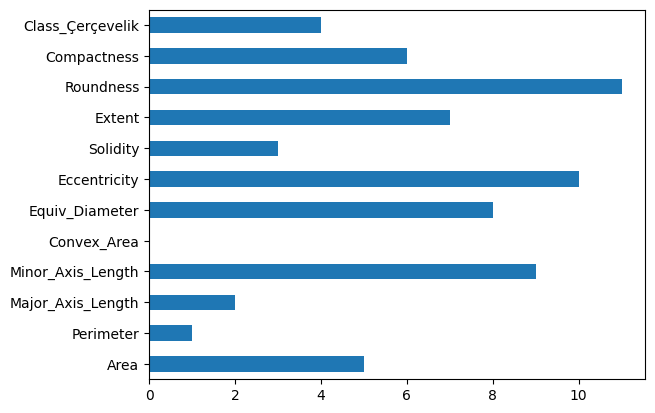

In [13]:
# pip install skfeature-chappers
from skfeature.function.similarity_based import fisher_score

# get the fisher's score rankings 
ranks = fisher_score.fisher_score(X.values, y.values)

# create a pandas DataFrame for easier interpretation
feat_importances = pd.Series(ranks, X.columns)
feat_importances.plot(kind='barh')

# how to interpret -> low score means the effect of this field is not large in the dataset
# => typically means other columns in the dataset have similar correlations, 
# therefore making this particular column not so useful since other columns 
# already fill this role for this correlation


<b>Following Variables seem to not make a big impact in order</b>
<ul>
<li>Convex Area</li>
<li>Permiter</li>
<li>Major_Axsis_Length</li>
<li>Solidity</li>
</ul>

<p>Roundness maybe has too much correlation, and needs to be remocved</p>

<h4>Sweetviz and y data</h4>

In [14]:
import sweetviz as sv
import pandas as pd

#Commented out for rerunns, since the report stays the same
#report=sv.analyze(df)
#report.show_html('viz_pumpkin_report.html')

Convex_Area, Solidity, Extend, Equic Diameter and Area  seem to have little Impact on aspect Ratio, an the other Hand Permitter and Major_Axsis_Length, seems to have a big effect <br>
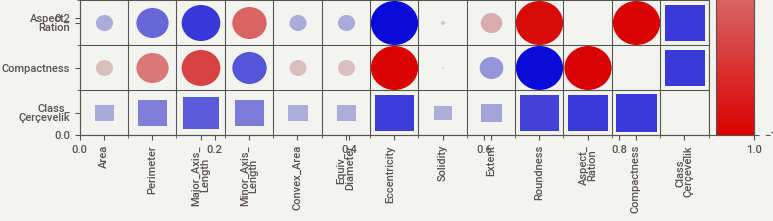 <br>

Compactness, Roundness, and Eccentricity may havetoo much correlation <br>
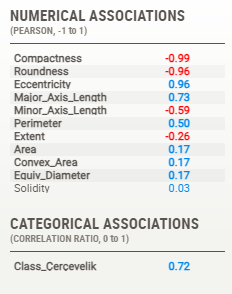

In [15]:
 # pip install ydata-profiling
from ydata_profiling import ProfileReport
import pandas as pd

#Commented out for rerunns, since the report stays the same
#report = ProfileReport(df, title='Pumpkin Seed Data')

#report.to_file("ydata_pumpkin_report.html")


<p>Solidity and Extend has no correlation with anything at all, it can be dropped without worries</p>
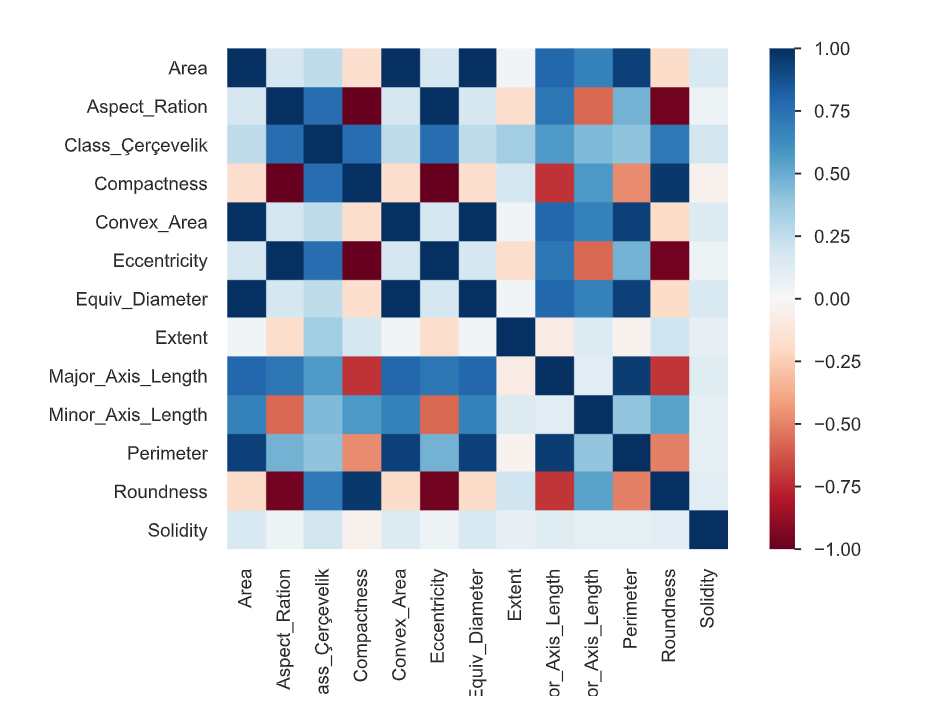

<b>Aspect_Ration has a high Correlation with Class_Çerçevelik, Compactness, Eccentricity, Major_Axis_Length, Roundness</b>
<ul>
<li>Class_Çerçevelik = 0.76 Good Correlation should be focused on</li>
<li>Compactness = -1.00 I think -1 means, something like mirrored, so drop </li>
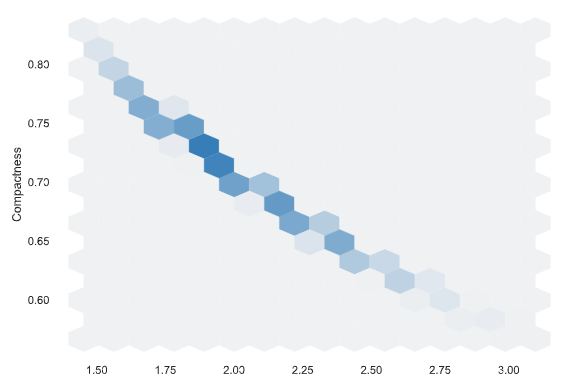
<li>Eccentricity = 1.00 = Drop</li>
<li>Major_Axis_Length = 0.72 = very good</li>
<li>Permiter = 0.47 many other interactions keep</li>
<li>Roundness = -0.96 I think the correlationis too high, and it should be dropped</li>
</ul>

<ul>
<li>Area = 0.16</li>
<li>Convex Area = 0.16</li>
<li>Equiv Diameter = 0.16</li>
</ul>

<h4>Trend</h4>
<p>I noticed a veryinterresting Trend, A lot of things that have minimal Correlation with area, have a lot of correlation with aspect ratio, and the other way around aswell</p>
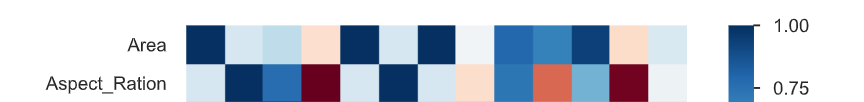
<p>Overall Aspect Ratio has little impact with Area,and yet seem to hold very much importance, since so many things impact aspect ratio</p>
<p>Overall i am not sure if i should maybe change the modell to predict aspect ratio instead of area, or drop aspect ratio</p>
<p>I have decided to change to modell towards asect ratio, meaning i have to redo the analysis, but i will leave this here, as symbol of my journey</p>

<h2>Summary, dropped Data:</h2>

<b>To Drop</b>
<ul>
<li>Extent</li>
<li>Solidity</li>
<li>Convex Area</li>
<li>Compactness</li>
<li>Eccentricity</li>
<li>Roundness</li>
</ul>


<b>To keep</b>
<ul>
<li>Class_Çerçevelik</li>
<li>Major_Axis_Length</li>
<li>Minor_Axis_Length</li>
<li>Perimeter</li>
<li>Area</li>
<li>Equiv Diameter</li>
</ul>

<p>Now the Data is prepared to be fit into a data modell</p>

<h3>Model Training</h3>

<p>First we try to have a model without optimization, andthen a model with removed collums and optimization</p>

<h4>Un-Optimized Model</h4>

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.2, random_state=101)

X_val, X_test, y_val, y_test=train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

print(f"Train data amount: {len(X_train)}")
print(f"Test data amount: {len(X_test)}")
print(f"Validation data amount: {len(X_val)}")

Train data amount: 1875
Test data amount: 235
Validation data amount: 234


In [17]:
var_ammount=len(X.columns)

model = keras.Sequential(
    [
        layers.Dense(13, activation="relu", input_shape=(var_ammount,)),
        layers.Dense(26, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)
    ]
)


model.compile(optimizer='adam', loss='mse')


model.summary()

c:\Users\janni\OneDrive\Fächer - Uni\5.Semester\VS_DeepL_AdDA\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 13)             │           169 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │           364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,070 (8.09 KB)

 Trainable params: 2,070 (8.09 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.fit(x=X_train, y=y_train, epochs=600, validation_data=(X_val, y_val))

Epoch 1/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 168179.3125 - val_loss: 669.5419
Epoch 2/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 273.0599 - val_loss: 21.2639
Epoch 3/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.8931 - val_loss: 21.0067
Epoch 4/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.9691 - val_loss: 20.9641
Epoch 5/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.1746 - val_loss: 20.8933
Epoch 6/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.2786 - val_loss: 21.7500
Epoch 7/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.3187 - val_loss: 20.8273
Epoch 8/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2991 - val_loss: 21.1302
Epoch 9/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2640 - val_loss: 21.1655
Epoch 10/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.9064 - val_loss: 22.4761
Epoch 11/600
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.8131 - val_loss: 26.2427
Epoch 12/600
59/59 ━━━━━━━━━━━━━━━━

<p> 1. Run <br> 
500 Epos, [
        layers.Dense(22, activation="relu", input_shape=(var_ammount,)),
        layers.Dense(34, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)
    ]
Inconsistent loss and val lost <br>
Test data evaluation:
0.0868 <br>
Train data evaluation:
0.089 <br>
Model Prediction seems flat. It just says the same thing everytime and is "close enough" i guess too much complex data
</p>

<p>MAE
0.24 Unit

MSE
0.09 Unit^2

RMSE:
0.29 Unit

R-squared:
-0.0

Explained variance score:
0.0</p>

Since its always less then 1 unity inaccurate, the model seems to feel like "close enough" and not improve at all, the problem is that the seed varies only from like 1.15 3.14 in aspect ratio 

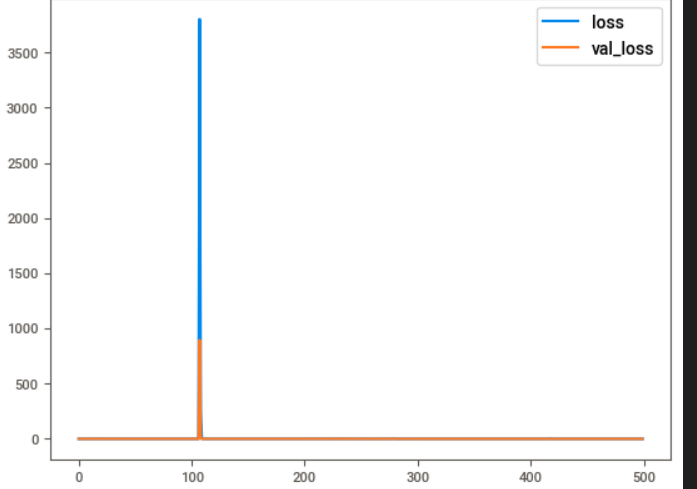
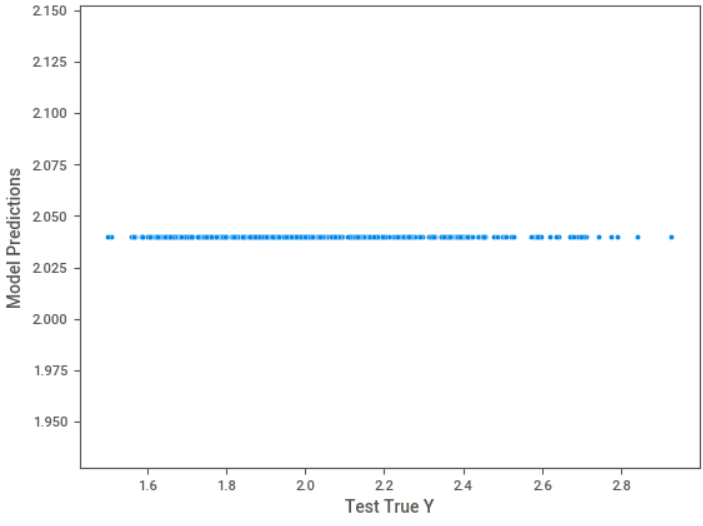


thats the end of the first run

<Axes: >

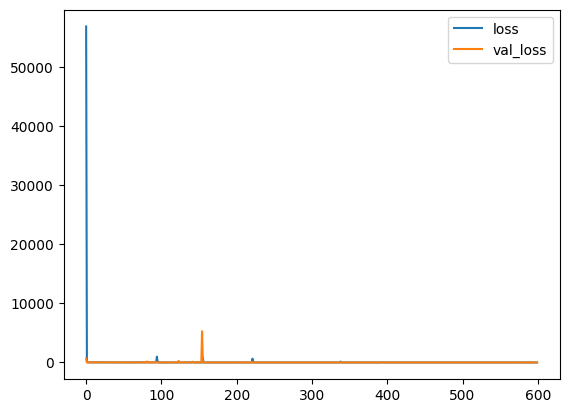

In [19]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [20]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
0.0027178023010492325

Train data evaluation:
0.0026846155524253845


In [21]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


,Test True Y,Model Predictions
0,2.1141,2.156480
1,2.5798,2.610734
2,1.9570,2.009187
3,2.5043,2.471299
4,1.6545,1.714921
...,...,...
230,2.2400,2.301713
231,1.9712,2.004228
232,1.8458,1.842698
233,2.6953,2.691545


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

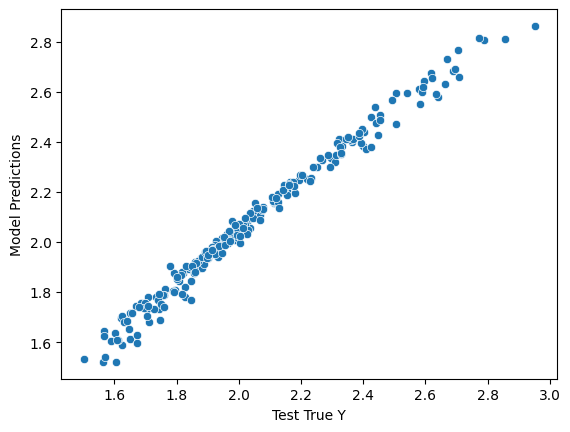

In [22]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [23]:
print("Mean average error")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "Units")

print("\nMean square error")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "Units^2")

print('\nRoot mean square error:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "Units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# the higher the score, the model is more able to explain the variation in the data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

Mean average error
0.05 Units

Mean square error
0.0 Units^2

Root mean square error:
0.05 Units

R-squared:
0.97

Explained variance score:
0.99


235

 Predictions 

235


C:\Users\janni\AppData\Local\Temp\ipykernel_15960\1872061308.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


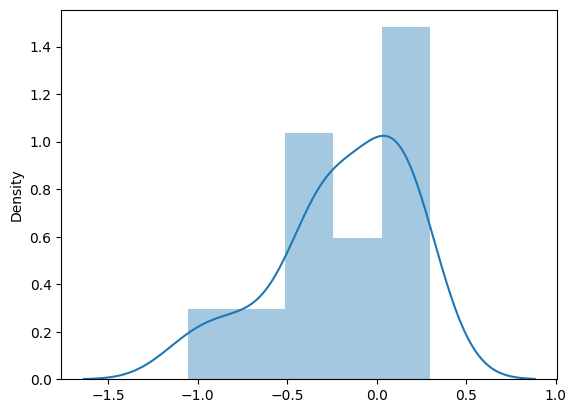

In [24]:
print(len(y_test))
print("\n Predictions \n")
print(len(test_predictions))
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [25]:
df.columns

Index(['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length',
       'Convex_Area', 'Equiv_Diameter', 'Eccentricity', 'Solidity', 'Extent',
       'Roundness', 'Aspect_Ration', 'Compactness', 'Class_Çerçevelik'],
      dtype='object')

In [26]:
X.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Compactness,Class_Çerçevelik
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,0.8207,1
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,0.7487,1
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,0.6929,1
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,0.7624,1
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,0.7557,1


In [27]:
tester_row = {
'Area': 66107,
'Perimeter': 998.15,
'Major_Axis_Length': 383.89,
'Minor_Axis_Length': 220.45,
'Convex_Area': 67117,
'Equiv_Diameter': 290.12,
'Eccentricity': 0.82,
'Solidity' :0.98,
'Extent': 0.68,
'Roundness': 0.83,
'Compactness': 0.76,
'Class_Çerçevelik': 1
}

#Aspect_Ration= 1.74

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [28]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated Aspect_Ration of the Pumpkin Seed:")
print(f"{round(float(result[0]), 5)} Units")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Estimated Aspect_Ration of the Pumpkin Seed:
1.77227 Units
----------------


<b>Summary after all the Testing Around</b>
<p></p>

<h3>Model Optimization</h3>
<p>Hypothesis, too much different data, that has an impact on outcomes with a similar Unit range, makes the model give up fast, if we remove a lot useless colums and change the model the learning might be better</p>

In [29]:
X = df[['Area','Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 
        'Equiv_Diameter', 'Class_Çerçevelik']]
#Cutting down colums by half
#Instead of dropping all the useless colums on the df we jsut dont scan for it

y=df['Aspect_Ration']

In [30]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)
print(f"Train data amount: {len(X_train)}")
print(f"Test data amount: {len(X_test)}")
print(f"Validation data amount: {len(X_val)}")

Train data amount: 1640
Test data amount: 352
Validation data amount: 352


In [47]:
variable_amount = len(X.columns)

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


mc = ModelCheckpoint('best_model_regression2.keras', monitor='val_loss', mode='min', save_best_only=True)

callback_list = [mc]


model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1,)),
        layers.Dropout(0.1),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)
    ]
)


model.compile(optimizer='adam', loss='mse')


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 269 (1.05 KB)

 Non-trainable params: 12 (48.00 B)

In [49]:
model.fit(x=X_train, y=y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0106
Epoch 2/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - val_loss: 0.0088
Epoch 3/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - val_loss: 0.0110
Epoch 4/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 - val_loss: 0.0102
Epoch 5/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - val_loss: 0.0094
Epoch 6/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - val_loss: 0.0103
Epoch 7/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.0129
Epoch 8/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0088
Epoch 9/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - val_loss: 0.0087
Epoch 10/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 - val_loss: 0.0090
Epoch 11/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - val_loss: 0.0100
Epoch 12/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

<h5>Training Metrics</h5>

<p> Summary 1.Run New Model</p>
<p> layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(20, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.1)),
        layers.Dropout(0.1),
        layers.Dense(14, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)</p>
<p> 800 Epochs</p>
<p>Test data evaluation:
0.0062
Train data evaluation:
0.0062
Evaluation is closer to 0 than on 1. model
</p>
<p>
Mean average error
0.02 Units

Mean square error
0.0 Units^2

Root mean square error:
0.03 Units

R-squared:
0.99

Explained variance score:
0.99

Close to perfect Model</p>

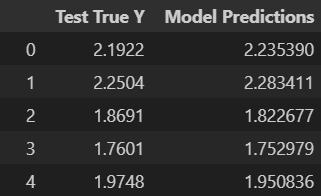
<p>Modell no longer makes negative or same guesses, it is very close to the actual value</p>

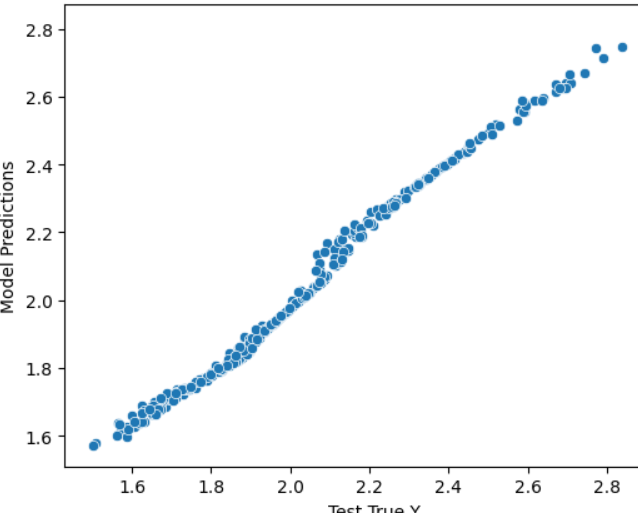
<p> The Predictions are very accurate</p>

<Axes: >

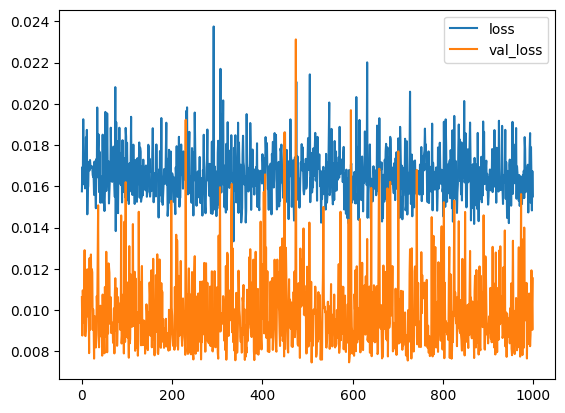

In [50]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

<h5>Checking the best Model</h5>

In [51]:
from keras.models import load_model
model = load_model('best_model_regression2.keras') 

In [52]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
0.006033323239535093

Train data evaluation:
0.006395032163709402


<h5>Predictions</h5>

In [53]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Test True Y,Model Predictions
0,2.1922,2.190051
1,2.2504,2.243867
2,1.8691,1.846306
3,1.7601,1.748071
4,1.9748,1.973865
...,...,...
347,2.5862,2.622156
348,2.1737,2.174376
349,1.9771,1.979819
350,1.6450,1.705061


<p>I dont know what to write here, but the model seems accurate to 1mm</p>

<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

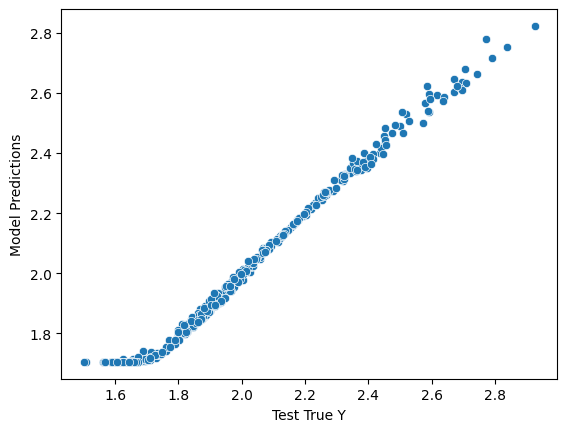

In [54]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

<p>Different from the first run: it seems to not have any problems in the middle anymore but the beginning seems weird</p>

In [55]:

print("Mean average error")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "Cm")

print("\nMean square error")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "Cm^2")

print('\nRoot mean square error:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "Cm")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# the higher the score, the model is more able to explain the variation in the data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

Mean average error
0.02 Cm

Mean square error
0.0 Cm^2

Root mean square error:
0.04 Cm

R-squared:
0.98

Explained variance score:
0.98


Having a Mean average error of 0.02 Means the model is on average only 2mm away from the real size

C:\Users\janni\AppData\Local\Temp\ipykernel_15960\3264322254.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


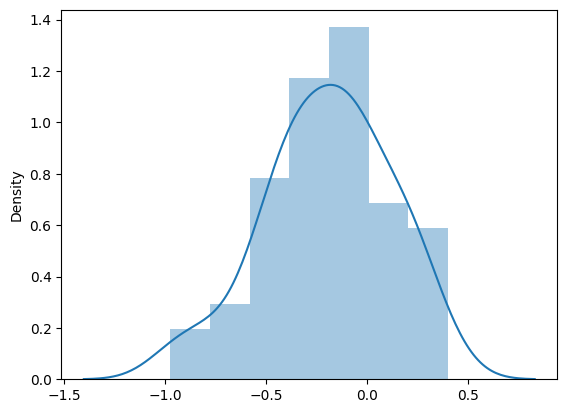

In [56]:
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [40]:
X.columns

Index(['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length',
       'Equiv_Diameter', 'Class_Çerçevelik'],
      dtype='object')

In [41]:
X.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Equiv_Diameter,Class_Çerçevelik
0,56276,888.242,326.1485,220.2388,267.6805,1
1,76631,1068.146,417.1932,234.2289,312.3614,1
2,71623,1082.987,435.8328,211.0457,301.9822,1
3,66458,992.051,381.5638,222.5322,290.8899,1
4,66107,998.146,383.8883,220.4545,290.1207,1


In [57]:
tester_row={
    'Area': 66107,
    'Perimeter': 998.146,
    'Major_Axis_Length': 383.8883,
    'Minor_Axis_Length': 220.4545,
    'Equiv_Diameter': 290.1207,
    'Class_Çerçevelik':1
}
tester_row = pd.DataFrame([tester_row])
#This is the data from number 4, to have a test with a very spezific example

In [58]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated Aspect_Ration of the Pumpkin Seed:")
print(f"{round(float(result[0]), 5)} Cm")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

Estimated Aspect_Ration of the Pumpkin Seed:
1.74399 Units
----------------


In [44]:
df.head(5)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class_Çerçevelik
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,1
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,1
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,1
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,1
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,1


Actual Aspect Ratio: 1.7413	= 0.2mm off

<h5> Test with made up example:</h5>

In [45]:
tester_row={
    'Area': 70107,
    'Perimeter': 900.146,
    'Major_Axis_Length': 300,
    'Minor_Axis_Length': 200,
    'Equiv_Diameter': 300,
    'Class_Çerçevelik':0
}
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]

print()
print(f"Estimated Aspect_Ration of the Pumpkin Seed:")
print(f"{round(float(result[0]), 5)} Cm")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Estimated Aspect_Ration of the Pumpkin Seed:
1.66241 Units
----------------
